# Лабораторная работа 4

### Экстраполяция населения страны (Новая Зеландия)

Методы:
- классическая полиномиальная интерполяция по Ньютону;
- кубический сплайн-интерполяция (естественный сплайн);
- аппроксимация методом наименьших квадратов.

Будем работать с оценками численности населения **Новой Зеландии** и
по историческим данным 1911–2018 годов экстраполировать значение на **2023 год**.

### Население Новой Зеландии (по данным переписей населения)

| Год  | Население, человек |
|------|--------------------|
| 1911 | 1 058 312          |
| 1921 | 1 271 668          |
| 1926 | 1 408 139          |
| 1936 | 1 573 812          |
| 1945 | 1 702 330          |
| 1951 | 1 939 472          |
| 1956 | 2 174 062          |
| 1966 | 2 676 919          |
| 1976 | 3 129 383          |
| 1986 | 3 307 084          |
| 1996 | 3 681 546          |
| 2001 | 3 820 750          |
| 2006 | 4 116 900          |
| 2013 | 4 242 048          |
| 2018 | 4 699 755          |

«Точное» значение для сравнения (Новая Зеландия, перепись 2023 года): **4 993 923 человек**.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["font.size"] = 12

Количество узлов: 15


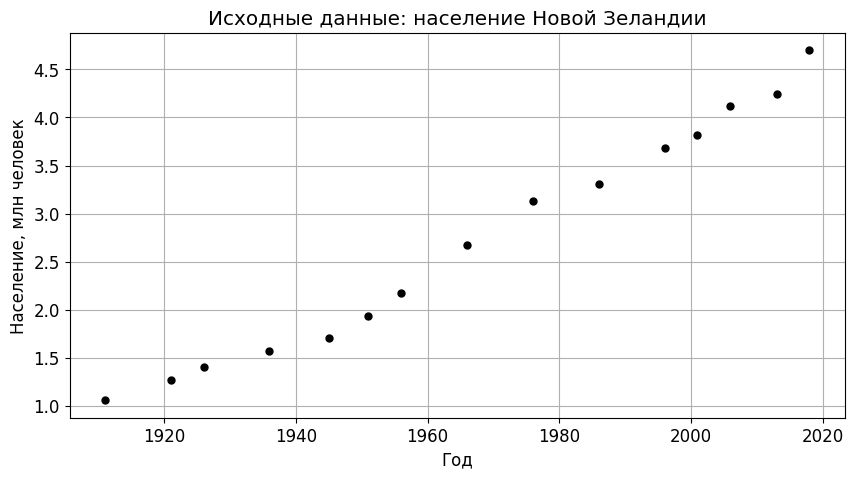

In [2]:
# входные данные

# Узлы интерполяции (годы) и значения (население, человек)
years = np.array([
    1911, 1921, 1926, 1936, 1945,
    1951, 1956, 1966, 1976, 1986,
    1996, 2001, 2006, 2013, 2018
], dtype=float)

population = np.array([
    1_058_312,
    1_271_668,
    1_408_139,
    1_573_812,
    1_702_330,
    1_939_472,
    2_174_062,
    2_676_919,
    3_129_383,
    3_307_084,
    3_681_546,
    3_820_750,
    4_116_900,
    4_242_048,
    4_699_755
], dtype=float)

year_predict = 2023
true_population_2023 = 4_993_923  # человек

print("Количество узлов:", len(years))

plt.scatter(years, population / 1e6, s=25, color="black")
plt.xlabel("Год")
plt.ylabel("Население, млн человек")
plt.title("Исходные данные: население Новой Зеландии")
plt.grid(True)
plt.show()


# Классическая полиномиальная интерполяция по Ньютону

In [3]:
class NewtonPolynomial:
    """
    Полиномиальная интерполяция в форме Ньютона.
    Строим полином степени n-1, проходящий через все точки (x_i, y_i).
    """
    def __init__(self, x, y):
        x = np.asarray(x, dtype=float)
        y = np.asarray(y, dtype=float)
        assert x.ndim == 1 and y.ndim == 1 and len(x) == len(y)

        self.x = x
        self.c = self._divided_differences(x, y)

    @staticmethod
    def _divided_differences(x, y):
        """
        Считаем таблицу разделённых разностей и возвращаем
        первый столбец — коэффициенты c_0, ..., c_{n-1}.
        """
        n = len(x)
        coef = y.astype(float).copy()
        for j in range(1, n):
            coef[j:n] = (coef[j:n] - coef[j-1:n-1]) / (x[j:n] - x[0:n-j])
        return coef

    def __call__(self, x_val):
        """
        Вычисление значения полинома в точке или в массиве точек x_val.
        Используем форму Ньютона с «обратной» схемой (аналог схемы Хорнера).
        """
        x_val = np.asarray(x_val, dtype=float)
        result = np.zeros_like(x_val) + self.c[-1]
        for k in range(len(self.c) - 2, -1, -1):
            result = result * (x_val - self.x[k]) + self.c[k]
        return result


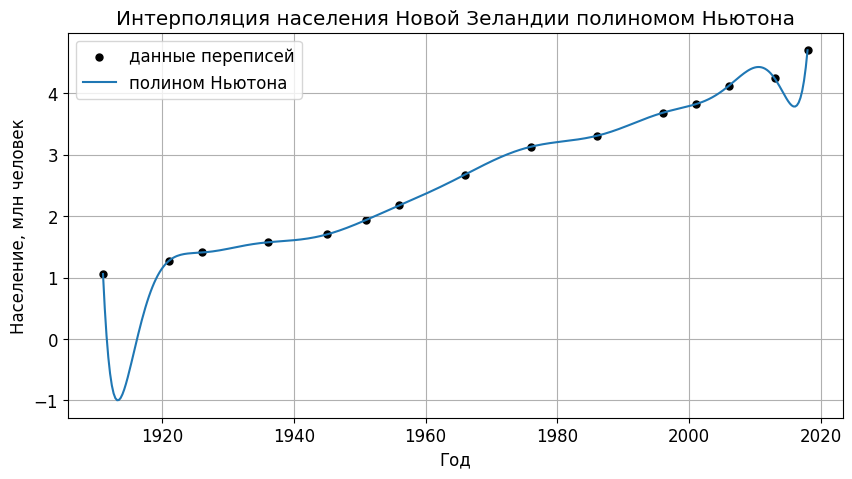

Оценка по Ньютону для 2023 года: 44,719,702 человек
Реальное значение: 4,993,923 человек
Абсолютная ошибка: 39,725,779 человек
Относительная ошибка: 795.48 %


In [4]:
# Построение бинома ньютона и оценка на 2023

newton_poly = NewtonPolynomial(years, population)

x_plot = np.linspace(years[0], years[-1], 400)
y_plot = newton_poly(x_plot) / 1e6  # в млн человек

plt.figure()
plt.scatter(years, population / 1e6, s=25, color="black", label="данные переписей")
plt.plot(x_plot, y_plot, label="полином Ньютона")
plt.xlabel("Год")
plt.ylabel("Население, млн человек")
plt.title("Интерполяция населения Новой Зеландии полиномом Ньютона")
plt.grid(True)
plt.legend()
plt.show()

prediction_newton = float(newton_poly(year_predict))

print(f"Оценка по Ньютону для {year_predict} года: {prediction_newton:,.0f} человек")
print(f"Реальное значение: {true_population_2023:,.0f} человек")
print(f"Абсолютная ошибка: {prediction_newton - true_population_2023:,.0f} человек")
print(f"Относительная ошибка: {abs(prediction_newton - true_population_2023) / true_population_2023 * 100:.2f} %")


### Результат для метода Ньютона

По результатам интерполяции полиномом Ньютона (степени 14, по 15 узлам)
население Новой Зеландии к 2023 году получается порядка **4.47 · 10⁷ человек**  
(≈ 44 719 702).

Реальное значение — **4 993 923 человека**, поэтому относительная ошибка
экстраполяции получается очень большой (порядка **795 %**).

Это наглядно показывает, что высокостепенной интерполяционный полином
очень плохо ведёт себя при экстраполяции за пределы интервала узлов.


# Сплайн-интерполяция

Используем **кубический естественный сплайн** на отрезке $[x_0, x_n]$.
На каждом промежутке $[x_i, x_{i+1}]$ сплайн задаётся многочленом

$$
S_i(x) = a_i + b_i (x - x_i) + c_i (x - x_i)^2 + d_i (x - x_i)^3,
\quad i = 0,\dots,n-1.
$$

Коэффициенты удобно выразить через значения вторых производных
$m_i = S''(x_i)$. Для *естественного* сплайна выполняются граничные условия

$$
m_0 = 0, \qquad m_n = 0.
$$

Обозначим $h_i = x_{i+1} - x_i$. Тогда внутренние моменты
$m_1, \dots, m_{n-1}$ находятся из трёхдиагональной системы

$$
h_{i-1} m_{i-1} + 2(h_{i-1}+h_i)m_i + h_i m_{i+1}
= 6\left(
\frac{f_{i+1}-f_i}{h_i} - \frac{f_i-f_{i-1}}{h_{i-1}}
\right), \quad i = 1,\dots,n-1.
$$

Эту систему решаем **методом трёхдиагональной прогонки**
(алгоритм Томаса), реализованным вручную.


In [5]:
def thomas_solve(lower, diag, upper, d):
    """
    Решение трёхдиагональной СЛАУ методом прогонки (алгоритм Томаса).

    lower — поддиагональ (длина n-1)
    diag  — главная диагональ (длина n)
    upper — наддиагональ (длина n-1)
    d     — правая часть (длина n)
    """
    lower = np.asarray(lower, dtype=float)
    diag = np.asarray(diag, dtype=float)
    upper = np.asarray(upper, dtype=float)
    d = np.asarray(d, dtype=float)

    n = len(diag)
    c_prime = np.zeros(n, dtype=float)
    d_prime = np.zeros(n, dtype=float)

    # Прямой ход
    c_prime[0] = upper[0] / diag[0]
    d_prime[0] = d[0] / diag[0]

    for i in range(1, n):
        denom = diag[i] - lower[i - 1] * c_prime[i - 1]
        if i < n - 1:
            c_prime[i] = upper[i] / denom
        d_prime[i] = (d[i] - lower[i - 1] * d_prime[i - 1]) / denom

    # Обратный ход
    x = np.zeros(n, dtype=float)
    x[-1] = d_prime[-1]
    for i in range(n - 2, -1, -1):
        x[i] = d_prime[i] - c_prime[i] * x[i + 1]

    return x


def natural_cubic_spline_moments(x, y):
    """
    Находит моменты m_i = S''(x_i) для естественного кубического сплайна.
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    n = len(x)

    h = np.diff(x)  # h_i = x_{i+1} - x_i, длина n-1

    # Система для m_1, ..., m_{n-1} (m_0 = m_n = 0)
    lower = h[:-1]                      # поддиагональ
    diag = 2 * (h[:-1] + h[1:])         # главная диагональ
    upper = h[1:]                       # наддиагональ
    d = 6 * ((y[2:] - y[1:-1]) / h[1:] - (y[1:-1] - y[:-2]) / h[:-1])

    m_inner = thomas_solve(lower, diag, upper, d)

    m = np.zeros(n, dtype=float)
    m[1:-1] = m_inner
    return m


class NaturalCubicSpline:
    """
    Естественный кубический сплайн по заданным узлам (x_i, y_i).
    """
    def __init__(self, x, y):
        self.x = np.asarray(x, dtype=float)
        self.y = np.asarray(y, dtype=float)
        self.m = natural_cubic_spline_moments(self.x, self.y)

    def _eval_scalar(self, xi):
        x, y, m = self.x, self.y, self.m

        # Находим отрезок [x_i, x_{i+1}], к которому принадлежит xi
        if xi <= x[0]:
            i = 0
        elif xi >= x[-1]:
            i = len(x) - 2
        else:
            i = np.searchsorted(x, xi) - 1

        h = x[i + 1] - x[i]
        t = x[i + 1] - xi
        u = xi - x[i]

        return (
            m[i] * t**3 / (6 * h)
            + m[i + 1] * u**3 / (6 * h)
            + (y[i] - m[i] * h**2 / 6) * t / h
            + (y[i + 1] - m[i + 1] * h**2 / 6) * u / h
        )

    def __call__(self, x_val):
        x_val = np.asarray(x_val, dtype=float)
        # Векторизуем вычисление по точкам
        return np.vectorize(self._eval_scalar)(x_val)


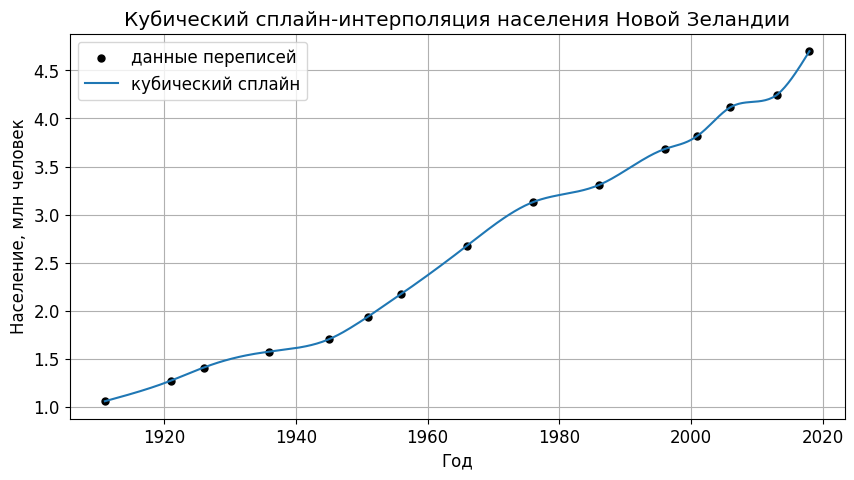

Оценка по сплайну для 2023 года: 5,157,462 человек
Реальное значение: 4,993,923 человек
Абсолютная ошибка: 163,539 человек
Относительная ошибка: 3.27 %


In [6]:
# Построение сплайна

spline = NaturalCubicSpline(years, population)

x_plot = np.linspace(years[0], years[-1], 400)
y_plot = spline(x_plot) / 1e6

plt.figure()
plt.scatter(years, population / 1e6, s=25, color="black", label="данные переписей")
plt.plot(x_plot, y_plot, label="кубический сплайн")
plt.xlabel("Год")
plt.ylabel("Население, млн человек")
plt.title("Кубический сплайн-интерполяция населения Новой Зеландии")
plt.grid(True)
plt.legend()
plt.show()

prediction_spline = float(spline(year_predict))

print(f"Оценка по сплайну для {year_predict} года: {prediction_spline:,.0f} человек")
print(f"Реальное значение: {true_population_2023:,.0f} человек")
print(f"Абсолютная ошибка: {prediction_spline - true_population_2023:,.0f} человек")
print(f"Относительная ошибка: {abs(prediction_spline - true_population_2023) / true_population_2023 * 100:.2f} %")


### Результат для сплайн-интерполяции

Кубический естественный сплайн даёт оценку населения Новой Зеландии в 2023 году
примерно **5.16 млн человек** (≈ 5 157 462).

При реальном значении 4.99 млн человек абсолютная ошибка составляет
около **164 тыс. человек**, относительная — примерно **3.27 %**.


# Метод наименьших квадратов

Теперь не будем требовать точного прохождения через все точки.
Будем аппроксимировать зависимость населения от времени
полиномом второй степени

$$
P(x) = a x^2 + b x + c.
$$

Коэффициенты $a, b, c$ найдём методом наименьших квадратов:
минимизируем сумму квадратов отклонений

$$
\sum_{k=0}^{n} (P(x_k) - f_k)^2.
$$

Это приводит к системе **нормальных уравнений** для трёх неизвестных,
которую решим численно.


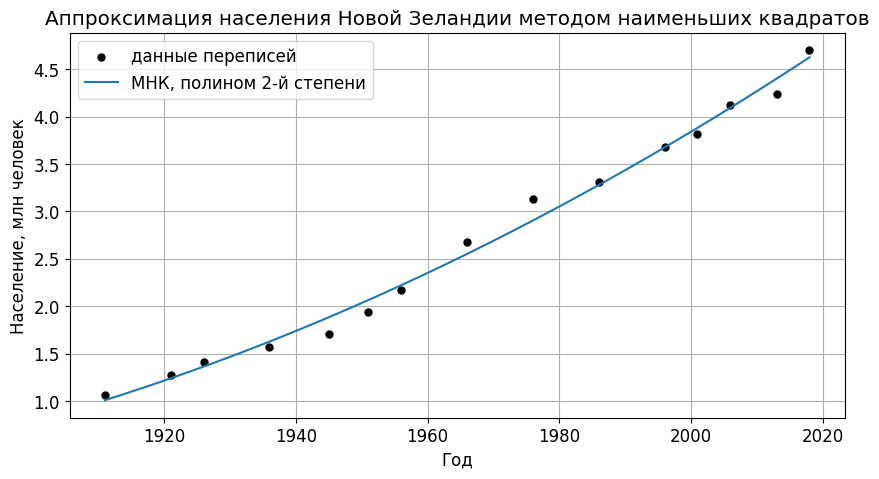

Оценка по МНК (квадратичный полином) для 2023 года: 4,855,273 человек
Реальное значение: 4,993,923 человек
Абсолютная ошибка: -138,650 человек
Относительная ошибка: 2.78 %


In [7]:
class LeastSquaresQuadratic:
    """
    Аппроксимация зависимости y(x) полиномом второй степени
    методом наименьших квадратов.
    """
    def __init__(self, x, y):
        self.x = np.asarray(x, dtype=float)
        self.y = np.asarray(y, dtype=float)
        self.c = self._compute_coeffs()  # [c0, c1, c2]

    def _compute_coeffs(self):
        x, y = self.x, self.y
        n = len(x)

        A = np.zeros((3, 3), dtype=float)
        b = np.zeros(3, dtype=float)

        # Элементы матрицы A: A_ij = sum x_k^{i+j}
        for i in range(3):
            for j in range(3):
                A[i, j] = np.sum(x**(i + j))

        # Компоненты вектора b: b_i = sum y_k * x_k^i
        for i in range(3):
            b[i] = np.sum(y * x**i)

        return np.linalg.solve(A, b)

    def __call__(self, x_val):
        x_val = np.asarray(x_val, dtype=float)
        c0, c1, c2 = self.c
        return c0 + c1 * x_val + c2 * x_val**2


ls_poly = LeastSquaresQuadratic(years, population)

x_plot = np.linspace(years[0], years[-1], 400)
y_plot = ls_poly(x_plot) / 1e6

plt.figure()
plt.scatter(years, population / 1e6, s=25, color="black", label="данные переписей")
plt.plot(x_plot, y_plot, label="МНК, полином 2-й степени")
plt.xlabel("Год")
plt.ylabel("Население, млн человек")
plt.title("Аппроксимация населения Новой Зеландии методом наименьших квадратов")
plt.grid(True)
plt.legend()
plt.show()

prediction_ls = float(ls_poly(year_predict))

print(f"Оценка по МНК (квадратичный полином) для {year_predict} года: {prediction_ls:,.0f} человек")
print(f"Реальное значение: {true_population_2023:,.0f} человек")
print(f"Абсолютная ошибка: {prediction_ls - true_population_2023:,.0f} человек")
print(f"Относительная ошибка: {abs(prediction_ls - true_population_2023) / true_population_2023 * 100:.2f} %")


## Сравнение трёх методов

Построим краткую сводку результатов экстраполяции населения Новой Зеландии
на 2023 год (реальное значение — **4 993 923 человека**).

| Метод                          | Оценка в 2023 г., чел | Абсолютная ошибка, чел | Относительная ошибка |
|--------------------------------|-----------------------|------------------------|-----------------------|
| Полином Ньютона (степень 14)   | ≈ 44 719 702          | ≈ 39 725 779           | ≈ 795 %               |
| Кубический естественный сплайн | ≈ 5 157 462           | ≈ 163 539              | ≈ 3.27 %              |
| МНК, полином 2-й степени       | ≈ 4 855 273           | ≈ 138 650              | ≈ 2.78 %              |

**Выводы:**

* Полиномиальная интерполяция по Ньютону при экстраполяции далеко
  за пределы узлов даёт катастрофически плохой результат  
  (переоценка почти на порядок).
* Кубический сплайн и аппроксимация методом наименьших квадратов дают
  уже реалистичные значения.
* В данном наборе данных наилучшую численную точность даёт
  **квадратичный полином МНК** (ошибка ≈ 2.8 %), сплайн немного уступает
  ему по точности, но тоже хорошо описывает общий тренд.